# Battle of the Sexes Self Play

In [41]:
import sys 
sys.path.append("../src")
import numpy
import matplotlib.pyplot as plt
import LearningGames

## Create game

In [42]:
class BS_selfplay:
    action_set={0,1}
    A1 =-numpy.array([[10,2],[0,7]])
    A2 =-numpy.array([[7,2],[0,10]])
    def __init__(self,length_measurement=1):
        """Create game

        Args:
            length_measurement (int): number of actions of other player to be used as measurement
        """
        self.length_measurement=length_measurement
        if length_measurement>0:
            # create outputs with all combinations of actions
            measurement_set={tuple([a]) for a in self.action_set}
            for i in range(length_measurement-1):
                new_measurement_set=set()
                for m in measurement_set:
                    for a in self.action_set:
                        new_measurement_set.add(m+tuple([a]))
                measurement_set=new_measurement_set
            print("Measurement set with {:d} elements".format(len(measurement_set)))
            if len(measurement_set)<28:
                print(measurement_set)
            self.measurement_set=measurement_set
            # initialize measurement
            self.measurement4player1=length_measurement*[1]
            self.measurement4player2=length_measurement*[1]
        else:
            self.measurement_set=[None]
            self.measurement4player1=None
            self.measurement4player2=None
    def cost(self,player1_action,player2_action) -> tuple[float,float]:
        """Returns game outcome

        Args:
            player1_action: action for player 1
            player2_action: action for player 2

        Returns:
            tuple[float,float]:
                player1_cost (float): cost for player 1
                player2_cost (float): cost for player 2
        """
        return (self.A1[player1_action,player2_action],self.A2[player1_action,player2_action])
    def get_measurement(self):
        """get measurement for next game

        Returns: tuple[str,str]
            measurement4player1: measurement for player 1 for the next game
            measurement4player2: measurement for player 2 for the next game
        """
        return (self.measurement4player1,self.measurement4player2)
    def play(self,player1_action,player2_action) -> tuple[float,float,dict[int,float],dict[int,float]]:      
        """Play game

        Args:
            player1_action: action for player 1
            player2_action: action for player 2

        Returns: 
            tuple[float,dict(str,float)]
                player1_cost (float): cost for player 1
                player2_cost (float): cost for player 2
                all_costs4player1 (dict[int,float]): dictionary with costs for all actions of player 1
                all_costs4player2 (dict[int,float]): dictionary with costs for all actions of player 2
        """
        # update measurement
        if self.length_measurement>0:
            self.measurement4player1=self.measurement4player1[1:]+player2_action
            self.measurement4player2=self.measurement4player2[1:]+player1_action
        # cost for given action of player 1
        (player1_cost,player2_cost)=self.cost(player1_action,player2_action)
        # costs for all actions of player 1
        all_costs4player1={a:self.cost(a,player2_action)[0] for a in self.action_set}
        all_costs4player2={a:self.cost(player1_action,a)[1] for a in self.action_set}
        return (player1_cost,player2_cost,all_costs4player1,all_costs4player2)
    

## Create Game and LearningGame objects

+ Against a static player, we can use `lambda=0`
+ Against a deterministic player, the temperature can be quite low. This will result in very fast learning.

In [43]:
game=BS_selfplay(length_measurement=0)
lg1=LearningGames.LearningGame(game.action_set,measurement_set=game.measurement_set,
                               decay_rate=0.0,inverse_temperature=.1,seed=None);
lg2=LearningGames.LearningGame(game.action_set,measurement_set=game.measurement_set,
                               decay_rate=0.0,inverse_temperature=.1,seed=None);

## Simulate game

In [44]:
lg1.reset()
lg2.reset()
M = 10000
player1_costs=numpy.zeros(M)
player2_costs=numpy.zeros(M)
player1_entropy=numpy.zeros(M)
player2_entropy=numpy.zeros(M)
player1_action=M*["-"]
player2_action=M*["-"]
for iter in range(M):
    # Play
    (measurement4player1,measurement4player2)=game.get_measurement()
    (player1_action[iter],_,player1_entropy[iter])=lg1.get_action(measurement4player1)
    (player2_action[iter],_,player2_entropy[iter])=lg2.get_action(measurement4player2)
    (player1_costs[iter],player2_costs[iter],all_costs4player1,all_costs4player2)=game.play(player1_action[iter],player2_action[iter])
    # Learn
    lg1.update_energies(measurement4player1, all_costs4player1)
    lg2.update_energies(measurement4player2, all_costs4player2)
    # output
    if iter<10:
        print("iter={:4d}, measurement4player1 = {:s}, player1_action = {:d}, measurement4player2 = {:s}, player2_action = {:d}, player1_cost = {:2.0f}, player2_cost = {:2.0f}, all_costs4player1 = {:s}, all_costs4player2 = {:s}".format(
            iter,str(measurement4player1),player1_action[iter],
            str(measurement4player2),player2_action[iter],
            player1_costs[iter],player2_costs[iter],
            str(all_costs4player1),str(all_costs4player2)))
    #print(lg.energy)
print("Regret for player 1:")
lg1.get_regret(display=True);
print(lg1.energy)
print(player1_action[-20:])
print("Regret for player 2:")
lg2.get_regret(display=True);
print(lg2.energy)
print(player2_action[-20:])


iter=   0, measurement4player1 = None, player1_action = 1, measurement4player2 = None, player2_action = 1, player1_cost = -7, player2_cost = -10, all_costs4player1 = {0: -2, 1: -7}, all_costs4player2 = {0: 0, 1: -10}
iter=   1, measurement4player1 = None, player1_action = 0, measurement4player2 = None, player2_action = 1, player1_cost = -2, player2_cost = -2, all_costs4player1 = {0: -2, 1: -7}, all_costs4player2 = {0: -7, 1: -2}
iter=   2, measurement4player1 = None, player1_action = 1, measurement4player2 = None, player2_action = 1, player1_cost = -7, player2_cost = -10, all_costs4player1 = {0: -2, 1: -7}, all_costs4player2 = {0: 0, 1: -10}
iter=   3, measurement4player1 = None, player1_action = 1, measurement4player2 = None, player2_action = 1, player1_cost = -7, player2_cost = -10, all_costs4player1 = {0: -2, 1: -7}, all_costs4player2 = {0: 0, 1: -10}
iter=   4, measurement4player1 = None, player1_action = 1, measurement4player2 = None, player2_action = 1, player1_cost = -7, player2

## Plot results

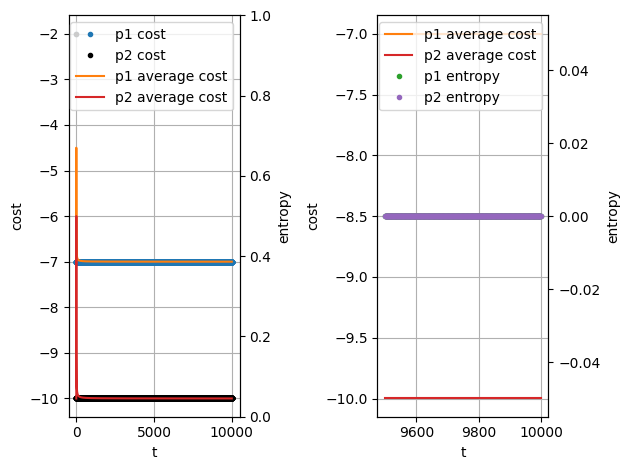

In [45]:
iters=range(M);
player1_average_costs=numpy.divide(numpy.cumsum(player1_costs),numpy.add(range(M),1))
player2_average_costs=numpy.divide(numpy.cumsum(player2_costs),numpy.add(range(M),1))
slc=slice(int(.95*M),M)
fig, ax=plt.subplots(1,2)
# Plot costs, average cost, and entropy, from start
ax_twin=ax[0].twinx()
lines=ax[0].plot(iters,player1_costs,'.',label='p1 cost',color='tab:blue')
lines+=ax[0].plot(iters,player2_costs,'.',label='p2 cost',color='black')
lines+=ax[0].plot(iters,player1_average_costs,'-',label='p1 average cost',color='tab:orange')
lines+=ax[0].plot(iters,player2_average_costs,'-',label='p2 average cost',color='tab:red')
#lines+=ax_twin.plot(iters,player1_entropy,'-',label='p1 entropy',color='tab:green')
#lines+=ax_twin.plot(iters,player2_entropy,'-',label='p2 entropy',color='tab:purple')
ax[0].grid()
ax[0].set_xlabel('t')
ax[0].set_ylabel('cost')
ax_twin.set_ylabel('entropy')
leg=ax_twin.legend(lines,[line.get_label() for line in lines])
#  Plot costs, average cost, and entropy, skipping start
ax_twin=ax[1].twinx()
lines=ax[1].plot(iters[slc],player1_average_costs[slc],'-',label='p1 average cost',color='tab:orange')
lines+=ax[1].plot(iters[slc],player2_average_costs[slc],'-',label='p2 average cost',color='tab:red')
lines+=ax_twin.plot(iters[slc],player1_entropy[slc],'.',label='p1 entropy',color='tab:green')
lines+=ax_twin.plot(iters[slc],player2_entropy[slc],'.',label='p2 entropy',color='tab:purple')
leg=ax_twin.legend(lines,[line.get_label() for line in lines])
ax[1].grid()
ax[1].set_xlabel('t')
ax[1].set_ylabel('cost')
ax_twin.set_ylabel('entropy')
fig.tight_layout()
plt.show();